# All the parameters that need to be changed

In [2]:
# Louisiana
state_ab = "la"

## Data
1. Download all the data in directory "la_data"
2. Eextract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest19_data = "./{}{}_vest_19/{}_vest_19.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/HB1_Congress_221ES.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/SB1_Senate_221ES.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/HB14_House_221ES.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

## Parameters that needs to be manually checked

### base vest data
start_col = 5\
vest_base_data = vest20\
year = '20'

### district data
district column name of cong_df, send, hdist when calling add_dist()

# Program starts

In [7]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph
import os
import math

maup.progress.enabled = True

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length)

    if maup.doctor(df) == False:
        #raise Exception('maup.doctor failed')
        print("Perhaps smart repair failed?")
        return df
    return df

In [10]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        if not math.isnan(election_df.at[precinct_index, dist_name]): #Note: added this b/c sen district has a hole over Lake Pontchartrain
            election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [11]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [12]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [13]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [14]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [15]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

## Read the census data

In [17]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [18]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [19]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [20]:
maup.doctor(population_df)

100%|█████████████████████████████████| 142874/142874 [00:55<00:00, 2553.83it/s]


True

In [21]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
               'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
               'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
               'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [22]:
population_df.rename(columns=rename_dict, inplace = True)

In [23]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['NH_WHITE'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['NH_BLACK'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['NH_AMIN'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['NH_ASIAN'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['NH_NHPI'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['NH_OTHER'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['NH_2MORE'], 1)

# Read the base vest data
Now using it as a "base precinct", but it could be vest 18 or vest 16 if vest 20 is not working

### Check if vest 20 can be used as base

In [26]:
vest20 = gpd.read_file(vest20_data)

### If it is true for maup doctor, we will use it as the base vest data.
Check where the election column starts, this should be the same for all vest data in that state

In [28]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREOWES', 'G20PREOOTH', 'G20USSRCAS', 'G20USSRMUR',
       'G20USSDPER', 'G20USSDEDW', 'G20USSDPIE', 'G20USSDKNI', 'G20USSDWEN',
       'G20USSLSIG', 'G20USSIMEN', 'G20USSOPRI', 'G20USSOJOH', 'G20USSNBIL',
       'G20USSNBOU', 'G20USSNMON', 'G20USSNDAR', 'geometry'],
      dtype='object')

## Parameters that need to be checked

In [30]:
start_col = 4
vest_base_data = vest20
year = '20'

In [31]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 258.21it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 1674.03it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 3857/3857 [00:02<00:00, 1791.16it/s]


Resolving overlaps and filling gaps...


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 1460.82it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 9: 100%|██████████████| 7/7 [00:00<00:00, 136.38it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s

In [32]:
borders = check_small_boundary_lengths(vest_base)
print(borders[2000:2500])

[16.243729451676256, 16.243729451676256, 16.252820697141086, 16.252820697141086, 16.421809227295388, 16.421809227295388, 16.718139766237428, 16.718139766237428, 17.204330030183296, 17.204330030183296, 17.61344416742733, 17.61344416742733, 17.701014950733633, 17.701014950733633, 17.71546892647184, 17.71546892647184, 18.0235251743226, 18.0235251743226, 18.215961460311245, 18.215961460311245, 19.077555588345568, 19.077555588345568, 19.164537508034797, 19.164537508034797, 19.51385285519756, 19.51385285519756, 19.6613076648474, 19.6613076648474, 20.055828807593343, 20.055828807593343, 20.545338913063627, 20.545338913063627, 20.652991514179437, 20.65299151417944, 20.718904874420836, 20.718904874420836, 20.799525813197466, 20.799525813197466, 21.2002898129059, 21.2002898129059, 21.550086633033178, 21.550086633033178, 21.71516567542154, 21.71516567542154, 22.357956673821327, 22.357956673821327, 22.75378040894954, 22.75378040894954, 23.737173841635418, 23.737173841635418, 24.345932220307613, 24

In [33]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 3796/3796 [00:00<00:00, 3980.90it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|█████████████████████████████████████| 3753/3753 [00:03<00:00, 1147.25it/s]


In [34]:
maup.doctor(vest_base)

100%|█████████████████████████████████████| 3753/3753 [00:03<00:00, 1228.48it/s]


True

In [35]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 3753/3753 [00:15<00:00, 238.59it/s]


In [36]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [37]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [38]:
election_df = gpd.GeoDataFrame(vest_base)

### Check if the population agrees

In [40]:
check_population(population_df, vest_base)

population agrees


# Add more vest data

In [42]:
vest19 = gpd.read_file(vest19_data)

In [43]:
vest19.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'G19GOVRRIS', 'G19GOVRABR',
       'G19GOVRLAN', 'G19GOVDEDW', 'G19GOVDDAN', 'G19GOVILAN', 'G19LTGRNUN',
       'G19LTGDJON', 'G19SOSRARD', 'G19SOSRKEN', 'G19SOSRSMI', 'G19SOSDCOL',
       'G19ATGRLAN', 'G19ATGDJAC', 'G19TRERSCH', 'G19TREDEDW', 'G19TRENKEN',
       'G19AGRRSTR', 'G19AGRRZAU', 'G19AGRDGR1', 'G19AGRDGR2', 'G19AGRDWIL',
       'G19INSRDON', 'G19INSRTEM', 'R19GOVRRIS', 'R19GOVDEDW', 'R19SOSRARD',
       'R19SOSDCOL', 'geometry'],
      dtype='object')

In [44]:
# check the result here
election_df = add_vest(vest19, election_df, '19', population_df, start_col)

100%|█████████████████████████████████████| 3752/3752 [00:03<00:00, 1184.47it/s]


There are 2 overlaps.
There are 1 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 3797/3797 [00:01<00:00, 3753.85it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████| 3753/3753 [00:15<00:00, 235.28it/s]


population agrees


In [45]:
vest18 = gpd.read_file(vest18_data)
vest18.columns

Index(['STATEFP10', 'COUNTYFP10', 'VTDST10', 'NAME10', 'G18SOSRARD',
       'G18SOSREDM', 'G18SOSRSTO', 'G18SOSRKEN', 'G18SOSRCRO', 'G18SOSRCLO',
       'G18SOSDCOL', 'G18SOSDFRE', 'G18SOSNMOR', 'R18SOSRARD', 'R18SOSDCOL',
       'geometry'],
      dtype='object')

In [46]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|█████████████████████████████████████| 3710/3710 [00:03<00:00, 1107.53it/s]


There are 1 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 3748/3748 [00:00<00:00, 3903.35it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 1/1 [00:00<00:00,  3.56it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████| 3753/3753 [00:16<00:00, 231.15it/s]


population agrees


In [47]:
vest16 = gpd.read_file(vest16_data)
vest16.columns

Index(['STATEFP10', 'COUNTYFP10', 'VTDST10', 'NAME10', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOMCM', 'G16PRECCAS',
       'G16PREOOTH', 'G16USSRKEN', 'G16USSRBOU', 'G16USSRFLE', 'G16USSRMAN',
       'G16USSRDUK', 'G16USSRCRA', 'G16USSRCAO', 'G16USSRMAR', 'G16USSRPAT',
       'G16USSDCAM', 'G16USSDFAY', 'G16USSDEDW', 'G16USSDLAN', 'G16USSDPEL',
       'G16USSDWIL', 'G16USSDMEN', 'G16USSLCLE', 'G16USSLGIL', 'G16USSOLAN',
       'G16USSOTAY', 'G16USSNBIL', 'G16USSNHEB', 'G16USSNMAR', 'G16USSNWEL',
       'R16USSRKEN', 'R16USSDCAM', 'geometry'],
      dtype='object')

In [48]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|█████████████████████████████████████| 3704/3704 [00:03<00:00, 1007.43it/s]


There are 1 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 3742/3742 [00:00<00:00, 3774.04it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 1/1 [00:00<00:00,  3.56it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████| 3753/3753 [00:15<00:00, 239.16it/s]


population agrees


## Add the district data

In [50]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [51]:
cong_df.head()

,ID,AREA,OBJECTID,DISTRICT_I,NAME,NUM_MEMBER,IDEAL_POP,IS_LOCKED,SHAPE_AREA,SHAPE_LEN,geometry
0,5,15208.31440,5,5,District 5,1,776292,0,3.746101,19.820423,"POLYGON ((586970.408 3652557.686, 587019.738 3..."
1,3,8612.33105,3,3,District 3,1,776292,0,2.082512,9.691517,"POLYGON ((619361.700 3374642.200, 619400.659 3..."
2,4,13676.68750,4,4,District 4,1,776292,0,3.369344,16.654527,"POLYGON ((586970.408 3652557.686, 586969.211 3..."
3,1,9001.86621,1,1,District 1,1,776292,0,2.170494,13.215370,"POLYGON ((735602.327 3369168.341, 735610.963 3..."
4,6,4452.85351,6,6,District 6,1,776292,1,1.077026,13.590078,"POLYGON ((624628.280 3374658.726, 626751.084 3..."


In [52]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT_I")

100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]


In [53]:
hdist.head()

,ID,AREA,OBJECTID,DISTRICT_I,NAME,NUM_MEMBER,IDEAL_POP,IS_LOCKED,SHAPE_AREA,SHAPE_LEN,geometry
0,17,1269.450560,12,12,District 12,1,44359,0,0.316265,2.972525,"POLYGON ((525709.508 3652915.871, 525811.686 3..."
1,7,3456.005120,47,47,District 47,1,44359,0,0.834558,6.079176,"POLYGON ((592502.996 3264406.166, 592334.652 3..."
2,20,231.143982,15,15,District 15,1,44359,0,0.057390,1.363273,"POLYGON ((554909.109 3595522.832, 554909.808 3..."
3,45,2135.672360,20,20,District 20,1,44359,0,0.527201,7.543825,"POLYGON ((563787.476 3577175.298, 563810.105 3..."
4,31,1065.128660,28,28,District 28,1,44359,0,0.260345,3.158888,"POLYGON ((594377.865 3466135.449, 594551.412 3..."


In [54]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT_I")

100%|█████████████████████████████████████████| 105/105 [00:02<00:00, 48.01it/s]


In [55]:
send.head()

,ID,AREA,OBJECTID,DISTRICT_I,NAME,NUM_MEMBER,IDEAL_POP,IS_LOCKED,SHAPE_AREA,SHAPE_LEN,geometry
0,21,3313.98730,33,33,District 33,1,119429,0,0.825928,8.256837,"POLYGON ((451340.946 3653469.830, 451925.690 3..."
1,20,4222.72119,32,32,District 32,1,119429,0,1.039192,11.102783,"POLYGON ((640889.366 3498100.539, 641057.299 3..."
2,12,2129.16577,26,26,District 26,1,119429,0,0.514721,4.514334,"POLYGON ((592502.996 3264406.166, 592334.652 3..."
3,18,1241.25817,29,29,District 29,1,119429,0,0.306078,9.155427,"POLYGON ((505733.459 3598528.950, 505741.902 3..."
4,15,1704.75268,35,35,District 35,1,119429,0,0.421254,6.352017,"POLYGON ((530306.552 3601140.898, 530382.934 3..."


In [56]:
election_df = add_district(send, "SEND", election_df, "DISTRICT_I")

100%|███████████████████████████████████████████| 39/39 [00:00<00:00, 95.26it/s]


There are 1 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████████████████████████████████████| 43/43 [00:00<00:00, 735.55it/s]


Resolving overlaps...
1 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 39/39 [00:00<00:00, 97.75it/s]


There are 1 holes.
Perhaps smart repair failed?


100%|███████████████████████████████████████████| 39/39 [00:00<00:00, 88.55it/s]


We can visually see that this hole is Lake Pontchartrain.  So as long as we didn't lose population, we should be fine.

<Axes: >

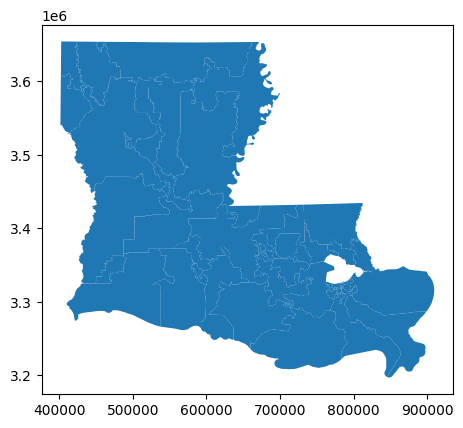

In [58]:
send.plot()

In [59]:
election_df = election_df.dropna(subset=['SEND'])

In [60]:
check_population(population_df, vest_base)

population agrees


In [61]:
election_df.columns

Index(['2MOREVAP', 'AGR19D', 'AGR19R', 'AMINVAP', 'ASIANVAP', 'ATG19D',
       'ATG19R', 'BVAP', 'COUNTYFP', 'GOV19D', 'GOV19O', 'GOV19R', 'HISP',
       'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'INS19R', 'LTG19D', 'LTG19R', 'NAME', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'SOS18D', 'SOS18O', 'SOS18R', 'SOS19D', 'SOS19R', 'STATEFP', 'TOTPOP',
       'TRE19D', 'TRE19O', 'TRE19R', 'USS16D', 'USS16O', 'USS16R', 'USS20D',
       'USS20O', 'USS20R', 'VAP', 'VTDST', 'WVAP', 'geometry', 'CD', 'HDIST',
       'SEND'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [63]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'GEOID':'GEOID'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [64]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'VTDST'+year,
    # 'GEOID'+year,
    'NAME'+year,
    'CD',
    # 'SEND', failed
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [65]:
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

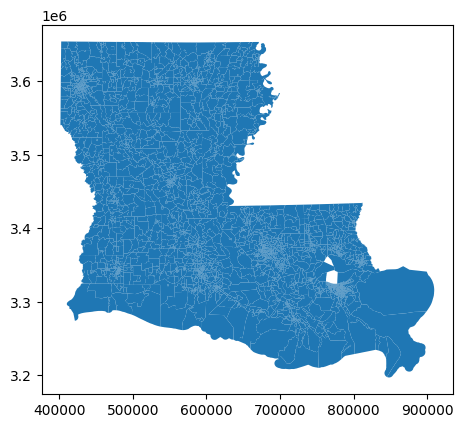

In [66]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()